<a href="https://colab.research.google.com/github/taba1/test1/blob/master/rbc51.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autograd

In [ ]:
!pip install matplotlib
!pip install scipy
!pip install matplotlib
!pip install --upgrade matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 85.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


Optimal allocation: K = 54.764574349859586, Kf = 36.50964576046795
Steady state: [ 1.      1.0204 54.7646  4.6103  3.6975  1.      1.0204 36.5096  4.6103
  3.6975 91.2742]
Debug - X_lag [ 1.      1.0204 54.7646  4.6103  3.6975  1.      1.0204 36.5096  4.6103
  3.6975 91.2742]
Debug - X [ 1.      1.0204 54.7646  4.6103  3.6975  1.      1.0204 36.5096  4.6103
  3.6975 91.2742]
Debug - X_prime [ 1.      1.0204 54.7646  4.6103  3.6975  1.      1.0204 36.5096  4.6103
  3.6975 91.2742]
Debug - X_lag [ 1.      1.0204 54.7646  4.6103  3.6975  1.      1.0204 36.5096  4.6103
  3.6975 91.2742]
Debug - X [ 1.      1.0204 54.7646  4.6103  3.6975  1.      1.0204 36.5096  4.6103
  3.6975 91.2742]
Debug - X_prime [ 1.      1.0204 54.7646  4.6103  3.6975  1.      1.0204 36.5096  4.6103
  3.6975 91.2742]
Result of F at the steady state: [ 0.     -0.0042 -0.1825  0.3488  0.      0.      0.      0.0058  0.1825
 -0.3937  0.    ]
Debug - X_lag [ 1.      1.0204 54.7646  4.6103  3.6975  1.      1.0204 36.5096

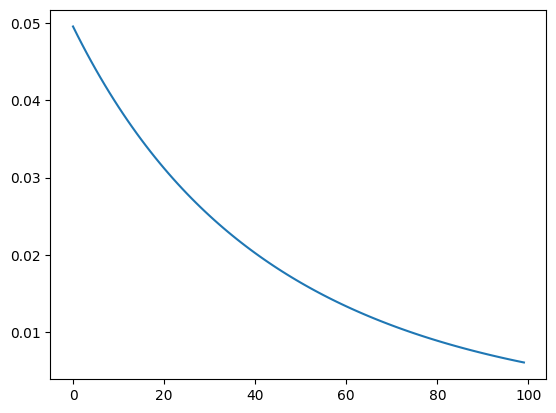

In [44]:
import autograd.numpy as np
from autograd import jacobian
np.set_printoptions(suppress=True,precision=4)

from Support import SolveSystem

# Indexing
nX = 11
nEps = 1
iZ, iR, iK, iY, iC, iZf, iRf, iKf, iYf, iCf,iTK= range(nX)


# Parameters
alpha = 0.4
beta = 0.98
gamma = 2.0
delta = 0.02
rho = 0.95

alphaf = 0.4
betaf = 0.98
gammaf = 2.0
deltaf = 0.02
rhof = 0.95
# 収益と分散
returns_home = 0.05  # 自国の収益
returns_foreign = 0.06  # 外国の収益
variance_home = 0.02  # 自国の分散
variance_foreign = 0.03  # 外国の分散

def optimize_allocation(K, Kf, TK, returns_home, returns_foreign, variance_home, variance_foreign):
    # 目的関数：分散を最小化
    def objective(x):
        K, Kf = x
        return K**2 * variance_home + Kf**2 * variance_foreign

    # 制約条件：資本の合計がTKと等しい
    constraints = ({'type': 'eq', 'fun': lambda x:  x[0] + x[1] - TK})

    # 初期値
    x0 = np.array([K, Kf])

    # 最適化問題を解く
    result = minimize(objective, x0, constraints=constraints)

    return result.x
#####################################
def SteadyState(returns_home, returns_foreign, variance_home, variance_foreign):
    Z = 1.
    R = 1/beta
    K = ((R-1+delta)/alpha)**(1./(alpha-1))
    Y = K**alpha
    C = Y - delta*K

    Zf = 1.
    Rf = 1/betaf
    Kf = ((R-1+deltaf)/alphaf)**(1./(alphaf-1))
    Yf = Kf**alphaf
    Cf = Yf - deltaf*Kf
    TK= K+Kf

    # 最適な資本配分を計算
    K_opt, Kf_opt = optimize_allocation(K, Kf, TK, returns_home, returns_foreign, variance_home, variance_foreign)
    print("Optimal allocation: K = {}, Kf = {}".format(K_opt, Kf_opt))

    X = np.zeros(nX)
    X[[iZ, iR, iK, iY, iC,iZf, iRf, iKf, iYf, iCf,iTK]]  = (Z, R, K_opt, Y, C,Zf,Rf,Kf_opt,Yf,Cf,TK)
    return X

##########################################


X_SS = SteadyState(returns_home, returns_foreign, variance_home, variance_foreign)

epsilon_SS = 0.0
epsilonf_SS = 0.0
print("Steady state: {}".format(X_SS))



# Model equations
def F(X_Lag,X,X_Prime,epsilon,epsilonf):

    # Unpack
    Z, R, K, Y, C, Zf, Rf, Kf, Yf, Cf,TK  = X
    Z_L, R_L, K_L, Y_L, C_L,Zf_L, Rf_L, Kf_L, Yf_L, Cf_L,TK_L  = X_Lag
    Z_P, R_P, K_P, Y_P, C_P,Zf_P, Rf_P, Kf_P, Yf_P, Cf_P,TK_P  = X_Prime

    print("Debug - X_lag",X_Lag)
    print("Debug - X",X )
    print("Debug - X_prime",X_Prime)



    return np.hstack((
            beta * R_P * C_P**(-gamma) * C**gamma - 1.0, # Euler equation
            alpha * Z  * K_L **(alpha-1) + 1 -delta - R, # MPK
            (1-delta) * K_L + Y - C - K,# Aggregate resource constraint
            Z * K_L**alpha - Y,# Production function
            rho * np.log(Z_L) + epsilon - np.log(Z),# TFP evolution
            K+Kf-TK, #この一部を海外資産の運用に配分する。ωを海外投資に向ける。
            #ωTKの資本形成の減少が自国には発生するが、一方で収益が増加する。
            #海外投資からの収益　Rf*omega*TK  omega*TK
            betaf * Rf_P * Cf_P**(-gamma) * Cf**gamma - 1.0, # Euler equation
            alphaf * Zf  * Kf_L **(alphaf-1) + 1 -deltaf - Rf, # MPK
            (1-deltaf) * Kf_L + Yf - Cf - Kf,# Aggregate resource constraint
            Zf * Kf_L**alphaf - Yf,# Production function
            rhof * np.log(Zf_L) + epsilonf - np.log(Zf)# TFP evolution
            ))
#########################
# Check steady state
try:
    assert( np.allclose( F(X_SS,X_SS,X_SS,epsilon_SS,epsilonf_SS) , np.zeros(nX)))
except AssertionError:
    # Check the result of the function F at the steady state
    result = F(X_SS,X_SS,X_SS,epsilon_SS,epsilonf_SS)

    # Print the result
    print("Result of F at the steady state: {}".format(result))


#######################

# Check steady state
#assert( np.allclose( F(X_SS,X_SS,X_SS,epsilon_SS,epsilonf_SS) , np.zeros(nX)))


# Linearize
A = jacobian(lambda x: F(X_SS,X_SS,x,epsilon_SS,epsilonf_SS))(X_SS)
B = jacobian(lambda x: F(X_SS,x,X_SS,epsilon_SS,epsilonf_SS))(X_SS)
C = jacobian(lambda x: F(x,X_SS,X_SS,epsilon_SS,epsilonf_SS))(X_SS)
E = jacobian(lambda x: F(X_SS, X_SS, X_SS, x, epsilonf_SS))(epsilon_SS)



P, Q = SolveSystem(A,B,C,E)


# Calculate an impulse response
IRF_RBC = np.zeros((nX,100))
IRF_RBC[:,0] = Q * 0.01

for t in range(1,100):
    IRF_RBC[:,t] = P@IRF_RBC[:,t-1]


# This material below runs only if this file is executed as a script
if __name__ == "__main__":


    print("A: {}".format(A))
    print("B: {}".format(B))
    print("C: {}".format(C))
    print("E: {}".format(E))

    import matplotlib.pyplot as plt
    plt.plot(IRF_RBC[iY,:])